In [1]:
## Importing libraries
import sys, os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore')

import seaborn as sns
import pandas as pd

from datetime import datetime

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout,RNN

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plotsize = (12,5)

In [2]:
# reading data
dataframe  = pd.read_csv("../input/covid19-in-india/covid_19_india.csv")

In [3]:
dataframe.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [4]:
dataframe.tail()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
18105,18106,2021-08-11,8:00 AM,Telangana,-,-,638410,3831,650353
18106,18107,2021-08-11,8:00 AM,Tripura,-,-,77811,773,80660
18107,18108,2021-08-11,8:00 AM,Uttarakhand,-,-,334650,7368,342462
18108,18109,2021-08-11,8:00 AM,Uttar Pradesh,-,-,1685492,22775,1708812
18109,18110,2021-08-11,8:00 AM,West Bengal,-,-,1506532,18252,1534999


In [5]:
dataframe.shape

(18110, 9)

In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       18110 non-null  int64 
 1   Date                      18110 non-null  object
 2   Time                      18110 non-null  object
 3   State/UnionTerritory      18110 non-null  object
 4   ConfirmedIndianNational   18110 non-null  object
 5   ConfirmedForeignNational  18110 non-null  object
 6   Cured                     18110 non-null  int64 
 7   Deaths                    18110 non-null  int64 
 8   Confirmed                 18110 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.2+ MB


In [7]:
# Dropping sno, which is not a necessary column to be present for description
dataframe.describe().drop('Sno', axis=1)

,Cured,Deaths,Confirmed
count,1.811000e+04,18110.000000,1.811000e+04
mean,2.786375e+05,4052.402264,3.010314e+05
std,6.148909e+05,10919.076411,6.561489e+05
min,0.000000e+00,0.000000,0.000000e+00
25%,3.360250e+03,32.000000,4.376750e+03
50%,3.336400e+04,588.000000,3.977350e+04
75%,2.788698e+05,3643.750000,3.001498e+05
max,6.159676e+06,134201.000000,6.363442e+06


### Pandas profiling to see automated EDA

In [8]:
import pandas_profiling as pp
profile = pp.ProfileReport(dataframe)
profile
# profile.to_file("output.html")

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Converting date column to a 'Datetime' object.

In [9]:
dataframe['Date'] = pd.to_datetime(dataframe['Date'])

#### Grouping data by 'Date' to find cumulative sum of cases in India.

In [10]:
data = dataframe.groupby(by=['Date']).sum().diff()
# np.diff --> substracting all the values from its previous values
# That is the reason all the first rows for each column are empty
data

# only int type columns got selected

,Sno,Cured,Deaths,Confirmed
Date,,,,
2020-01-30,NaN,NaN,NaN,NaN
2020-01-31,1.0,0.0,0.0,0.0
2020-02-01,1.0,0.0,0.0,1.0
2020-02-02,1.0,0.0,0.0,1.0
2020-02-03,1.0,0.0,0.0,0.0
...,...,...,...,...
2021-08-07,1296.0,40017.0,617.0,38628.0
2021-08-08,1296.0,43910.0,491.0,39070.0
2021-08-09,1296.0,39686.0,447.0,35499.0


#### Removing 'NAN' values and replacing with 0.

In [11]:
data.fillna(0,inplace=True)
data.rename(columns={"Confirmed":"Cases"},inplace=True)

In [12]:
data

,Sno,Cured,Deaths,Cases
Date,,,,
2020-01-30,0.0,0.0,0.0,0.0
2020-01-31,1.0,0.0,0.0,0.0
2020-02-01,1.0,0.0,0.0,1.0
2020-02-02,1.0,0.0,0.0,1.0
2020-02-03,1.0,0.0,0.0,0.0
...,...,...,...,...
2021-08-07,1296.0,40017.0,617.0,38628.0
2021-08-08,1296.0,43910.0,491.0,39070.0
2021-08-09,1296.0,39686.0,447.0,35499.0


### Plotting time series of 3 Variables.
1. Cases
2. Deaths
3. Cured

<AxesSubplot:title={'center':'Cured'}, xlabel='Date'>

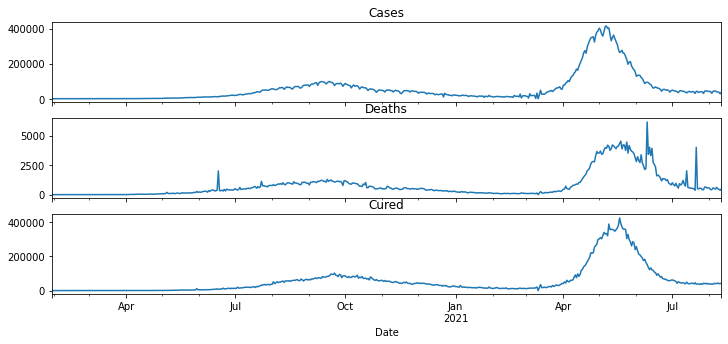

In [13]:
figure, axes = plt.subplots(3,sharex=True)
data['Cases'].plot(ax=axes[0],title='Cases',figsize=plotsize)
data['Deaths'].plot(ax=axes[1],title='Deaths',figsize=plotsize)
data['Cured'].plot(ax=axes[2],title='Cured',figsize=plotsize)

### Resampling number of cases by:
1. Weekly data
2. Monthly data

<AxesSubplot:title={'center':'Weekly cases'}, xlabel='Date'>

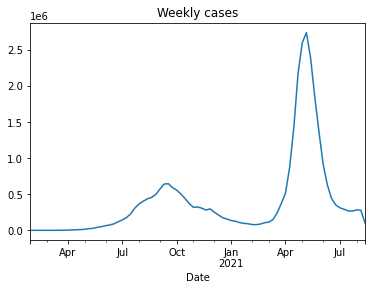

In [14]:
cases_weekly = data['Cases'].resample('W').sum()
cases_weekly.plot(title='Weekly cases')

<AxesSubplot:title={'center':'Monthly cases'}, xlabel='Date'>

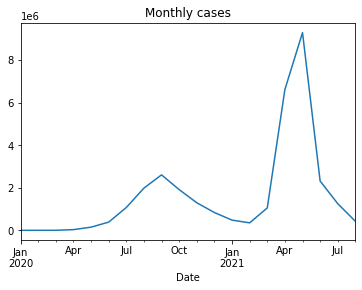

In [15]:
cases_monthly = data['Cases'].resample('M').sum()
cases_monthly.plot(title='Monthly cases')

### Setting up helper functions for forecasting

1. get_n_last_days : Extracting last n_days from the time series.
2. plot_n_last_days : Plotting last n_days from the time series

In [16]:
data
# date became the index column

,Sno,Cured,Deaths,Cases
Date,,,,
2020-01-30,0.0,0.0,0.0,0.0
2020-01-31,1.0,0.0,0.0,0.0
2020-02-01,1.0,0.0,0.0,1.0
2020-02-02,1.0,0.0,0.0,1.0
2020-02-03,1.0,0.0,0.0,0.0
...,...,...,...,...
2021-08-07,1296.0,40017.0,617.0,38628.0
2021-08-08,1296.0,43910.0,491.0,39070.0
2021-08-09,1296.0,39686.0,447.0,35499.0


In [17]:
def get_n_last_days(df, series_name, n_days):
    return df[series_name][-(n_days):] 

def plot_n_last_days(df, series_name, n_days):
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded day')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

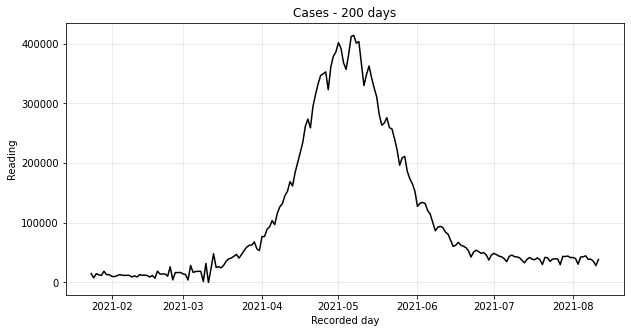

In [18]:
plot_n_last_days(data,'Cases',200)

### Some more helper functions
1. get_keras_format_series :  Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]


2. get_train_test_data : Utility processing function that splits an hourly time series into train and test with keras-friendly format, according to user-specified choice of shape.  
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns.

    series_name (string): column name in df.

    series_days (int): total days to extract.

    input_days (int): length of sequence input to network.

    test_days (int): length of held-out terminal sequence.
    
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     

In [19]:
def get_keras_format_series(series):

    series = np.array(series)
    return series.reshape(series.shape[0],series.shape[1],1) # converting to 3d



def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):

    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

In [20]:
series_days = 600
input_days = 5
test_days = 10

train_X, test_X_init, train_y, test_y = get_train_test_data(data, 'Cases', series_days, 
                         input_days, test_days)

In [21]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (182, 5, 1)
Training output shape: (182,)
Test input shape: (5,)
Test output shape: (5,)


### Defining deep learning model architecture

1. LSTM

    Fit LSTM to data train_X, train_y .
    
    arguments

    train_X (array): input sequence samples for training.

    train_y (list): next step in sequence targets.

    cell_units (int): number of hidden units for LSTM cells.

    epochs (int): number of training epochs   
   


In [22]:
def fit_LSTM(X_train, y_train, epochs):
    
    # initialize model
    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 45, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer nd some Dropout regularisation
    regressor.add(LSTM(units = 45, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 45, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 45))
    regressor.add(Dropout(0.2))

    # Adding the output layer
    regressor.add(Dense(units = 1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    regressor.compile(loss='mean_squared_error', optimizer='adam')
    regressor.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return regressor

In [23]:
model1 = fit_LSTM(train_X, train_y, epochs=1000)

Epoch 1/1000
3/3 [==============================] - 7s 21ms/step - loss: 8912587392.0000
Epoch 2/1000
3/3 [==============================] - 0s 23ms/step - loss: 9948118784.0000
Epoch 3/1000
3/3 [==============================] - 0s 23ms/step - loss: 10377848320.0000
Epoch 4/1000
3/3 [==============================] - 0s 22ms/step - loss: 9323213824.0000
Epoch 5/1000
3/3 [==============================] - 0s 22ms/step - loss: 10318482688.0000
Epoch 6/1000
3/3 [==============================] - 0s 20ms/step - loss: 10656891392.0000
Epoch 7/1000
3/3 [==============================] - 0s 23ms/step - loss: 9766543744.0000
Epoch 8/1000
3/3 [==============================] - 0s 20ms/step - loss: 9364569344.0000
Epoch 9/1000
3/3 [==============================] - 0s 20ms/step - loss: 11281137920.0000
Epoch 10/1000
3/3 [==============================] - 0s 19ms/step - loss: 10706535424.0000
Epoch 11/1000
3/3 [==============================] - 0s 19ms/step - loss: 8813629440.0000
Epoch 12/1000


### Making predictions.

Functions used
1. predict :  Given an input series matching the model's expected format generates model's predictions for next n_steps in the series.

2. predict_and_plot: Given an input series matching the model's expected format generates model's predictions for next n_steps in the series, and plots these predictions against the ground truth for those steps 
    
    arguments

    X_init (array): initial sequence, must match model's input shape.

    y (array): true sequence values to predict, follow X_init.

    model (keras.models.Sequential): trained neural network.

    title (string): plot title.  

In [24]:
def mse(observations, estimates):

    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [25]:
def predict(X_init, n_steps, model):

    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:]
        X_init[:,-1,:] = pred 
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):

    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_days)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])
    print(y_preds)
    print("MSE:{}".format(np.mean(mse(y,y_preds))))

[[144.91647]
 [144.91647]
 [144.91647]
 [144.91647]
 [144.91647]]
MSE:6493190882.406282


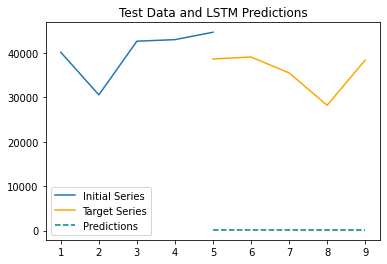

In [26]:
predict_and_plot(test_X_init, test_y, model1,
                 'Test Data and LSTM Predictions')

The deep learning model fails to learn due to small number of training instances.

### Decomposing the Time series.

Any time series has 3 components associated with it:
1. Trend
2. Seasonality
3. Residual

Analysing Number of cases

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
data.drop(columns=['Cured','Deaths'],inplace=True)
data.columns = ['ds', 'y']
ss_decomposition = seasonal_decompose(x=data['y'], model='additive',freq=7)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

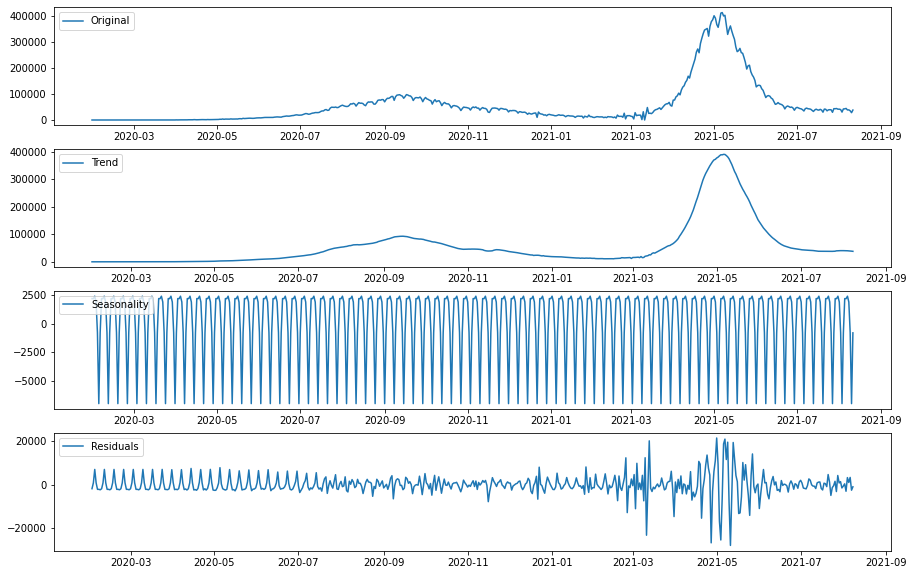

In [28]:
fig, axes = plt.subplots(4, 1)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(data['y'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

### Plotting Auto-Corellation function

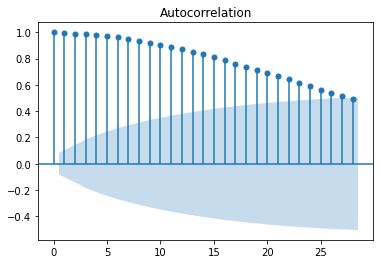

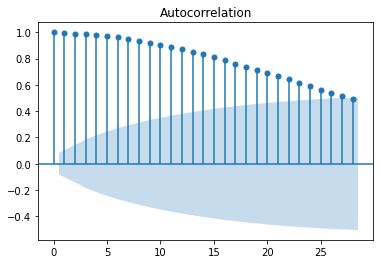

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['y'])

In [30]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

### Dividing the dataset into chunks to analyze data in specific time periods

In [31]:
chunks = np.split(data['y'], indices_or_sections=7)
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i, chunk in enumerate(chunks, 1):
    print("{:5} | {:.6} | {:.6}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
--------------------------
    1 | 184.887 | 1.1217e+05
    2 | 8810.91 | 4.13014e+07
    3 | 63736.3 | 4.45678e+08
    4 | 50819.1 | 2.60425e+08
    5 | 15910.3 | 3.01917e+07
    6 | 1.92165e+05 | 1.94989e+10
    7 | 68829.7 | 2.32563e+09


<AxesSubplot:>

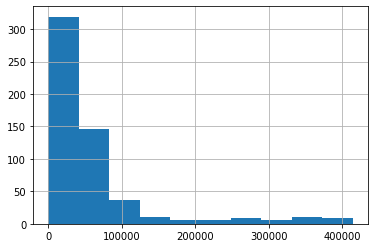

In [32]:
pd.Series(data['y']).hist()

### Augmented Dickey Fuller test (ADF Test)
* is a common statistical test used to test whether a given Time series is stationary or not. 

In [33]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data['y'])

In [34]:
print("ADF:{}".format(adf))
print("Pvalue:{}".format(pvalue))

ADF:-3.1521311886760373
Pvalue:0.022928166916663568


In [35]:
0.022928166916663568 < 0.05

True

p-value obtained is less than significance level (0.05). Hence we reject the null hypothesis. Therefore, We conclude the Time series is stationary.

### Dividing Time series into Train and test for predictions.

We will be making predictions for 30 days

In [36]:
train = np.array(data['y'][1:-30])
test = np.array(data['y'][-30:])

In [37]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [37175.79157993 37175.79157993 37175.79157993 37175.79157993
 37175.79157993 37175.79157993 37175.79157993 37175.79157993
 37175.79157993 37175.79157993 37175.79157993 37175.79157993
 37175.79157993 37175.79157993 37175.79157993 37175.79157993
 37175.79157993 37175.79157993 37175.79157993 37175.79157993
 37175.79157993 37175.79157993 37175.79157993 37175.79157993
 37175.79157993 37175.79157993 37175.79157993 37175.79157993
 37175.79157993 37175.79157993]
MSE:  664556681.3479285


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


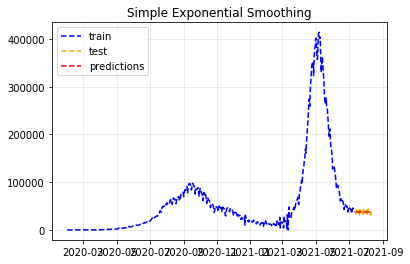

In [38]:
plt.plot(data.index[1:-30], train, 'b--', label="train")
plt.plot(data.index[-30:], test, color='orange', linestyle="--", label="test")
plt.plot(data.index[-30:], single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Simple Exponential Smoothing")
plt.grid(alpha=0.3);

In [39]:
from statsmodels.tsa.api import Holt

double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [36495.44143945 35386.50444865 34277.56745785 33168.63046704
 32059.69347624 30950.75648543 29841.81949463 28732.88250383
 27623.94551302 26515.00852222 25406.07153141 24297.13454061
 23188.19754981 22079.260559   20970.3235682  19861.38657739
 18752.44958659 17643.51259579 16534.57560498 15425.63861418
 14316.70162337 13207.76463257 12098.82764177 10989.89065096
  9880.95366016  8772.01666935  7663.07967855  6554.14268775
  5445.20569694  4336.26870614]
MSE:  13456167365.577461


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


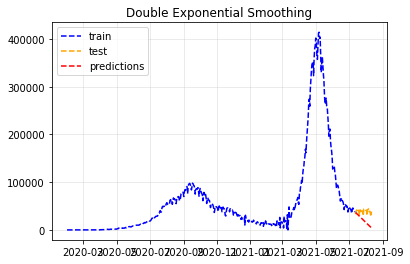

In [40]:
plt.plot(data.index[1:-30], train, 'b--', label="train")
plt.plot(data.index[-30:], test, color='orange', linestyle="--", label="test")
plt.plot(data.index[-30:], double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")
plt.grid(alpha=0.3);

In [41]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=13).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [36872.45523049 35878.61815531 34888.02054237 33902.7263936
 32912.53369533 31921.14646375 30922.53461835 29931.02312208
 28945.29292087 27951.08961996 26965.53420593 25972.27592862
 24978.08047635 23985.53121296 22991.69413777 22001.09652483
 21015.80237606 20025.60967779 19034.22244621 18035.61060081
 17044.09910454 16058.36890333 15064.16560242 14078.61018839
 13085.35191108 12091.15645881 11098.60719542 10104.77012023
  9114.17250729  8128.87835852]
MSE:  10736586421.807472


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


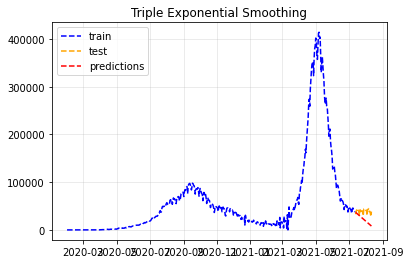

In [42]:
plt.plot(data.index[1:-30], train, 'b--', label="train")
plt.plot(data.index[-30:], test, color='orange', linestyle="--", label="test")
plt.plot(data.index[-30:], triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

### Comparing the results of the 3 statistical models.

In [43]:
print("Single MSE :{}".format(single_mse))
print("Double MSE :{}".format(double_mse))
print("Triple MSE :{}".format(triple_mse))

Single MSE :664556681.3479285
Double MSE :13456167365.577461
Triple MSE :10736586421.807472
